<a href="https://colab.research.google.com/github/shirish-baral/deep-learning/blob/main/CNN_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader # Corrected 'Dataloader' to 'DataLoader'
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert MINST Image files into Tensor of 4-Dimension (# of images, Height, Width)
transform = transforms.ToTensor()

In [ ]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:14<00:00, 692kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.14MB/s]


In [ ]:
# Test Data
# Train Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

# **Convolution Neural Network**

In [ ]:
# Create a small batch size for images..10 here
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
# Define CNN Model
# Describe Convolutional Layer -- 2 layers
# input, output, kernel size, stride
# no need of padding in this data
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

Input channel is 1 because MNIST is grayscale data

Else, it would have been 3 for RGB

nn.Conv2d is the class for creating 2D convolutional layers.

In [ ]:
# Grab 1 MNIST record
for i, (X_Train, y_train) in enumerate (train_data):
  break

This starts a loop that iterates through the train_data. enumerate() is used to get both the index (i) and the data for each item in the dataset. Each item from the train_data is a tuple containing an image (X_Train) and its corresponding label (y_train).

After this code runs, i will be 0, X_Train will hold the first image tensor, and y_train will hold the label for that image.

In [ ]:
X_Train.shape

torch.Size([1, 28, 28])

1 image of size 28x28

In [ ]:
x = X_Train.view(1,1,28,28)
# 1 batch, 1 image of size 28x28

In [ ]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [ ]:
x.shape
# 1 single image, 6 is filters we asked, 26x26 image

torch.Size([1, 6, 26, 26])

In [ ]:
# pass through the pooling layer
x = F.max_pool2d(x,2,2) #x input, kernel of 2, stride of 2

In [ ]:
x.shape
# 1 image, 6 filters , 26/2 = 13

torch.Size([1, 6, 13, 13])

In [ ]:
# Second convolution layer
x = F.relu(conv2(x))

In [ ]:
x.shape # no passing so 2 pixels lost around image

torch.Size([1, 16, 11, 11])

In [ ]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape #11/2 = 5.5 i.e. 5

torch.Size([1, 16, 5, 5])

28x28 -convolution layer-> 26x26 -pooling-> 13x13 -conv-> 11x11 -pooling-> 5x5

# **Create Model Class**

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully Connected Neural Layer
    # Assuming the output of the last pooling layer is 5x5 with 16 channels
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # First Pass: Conv1 -> ReLU -> Pool
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2

    # Second Pass: Conv2 -> ReLU -> Pool
    X = F.relu(self.conv2(X)) # Corrected: use self.conv2 and input X
    X = F.max_pool2d(X, 2, 2) # Corrected: input should be X

    # Re-View to flatten it out for the fully connected layers
    X = X.view(-1, 16*5*5) # negative 1 for batch size, 16 channels * 5x5 spatial

    # Fully Connected Layers: fc1 -> ReLU -> fc2 -> ReLU -> fc3
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) # Output layer, no activation for classification (Softmax typically in loss)

    return F.log_softmax(X, dim=1) # Added log_softmax for compatibility with NLLLoss or CrossEntropyLoss

In [ ]:
# Let's check model
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#smaller learning rate takes longer time

In [ ]:
import time
start_time = time.time()

# Create Variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For Looop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from training set. Not flattened
    loss = criterion(y_pred, y_train) # how off are we?

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss.item()) # Call .item() to append the float value
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss=criterion(y_val, y_test)
  test_losses.append(loss.item()) # Call .item() to append the float value
  test_correct.append(tst_corr)
  print(f'Epoch: {i} Train Loss: {train_losses[-1]} Train Accuracy: {train_correct[-1]} Test Loss: {test_losses[-1]} Test Accuracy: {test_correct[-1]}')


current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60}minutes!')

Epoch: 0 Batch: 600 Loss: 0.07375580817461014
Epoch: 0 Batch: 1200 Loss: 0.03078717552125454
Epoch: 0 Batch: 1800 Loss: 0.18898631632328033
Epoch: 0 Batch: 2400 Loss: 0.009293713606894016
Epoch: 0 Batch: 3000 Loss: 0.16961804032325745
Epoch: 0 Batch: 3600 Loss: 0.0024006678722798824
Epoch: 0 Batch: 4200 Loss: 0.44767388701438904
Epoch: 0 Batch: 4800 Loss: 0.002398066921159625
Epoch: 0 Batch: 5400 Loss: 0.06419529020786285
Epoch: 0 Batch: 6000 Loss: 0.00153863406740129
Epoch: 0 Train Loss: 0.00153863406740129 Train Accuracy: 56206 Test Loss: 0.003864265512675047 Test Accuracy: 9500
Epoch: 1 Batch: 600 Loss: 0.017309056594967842
Epoch: 1 Batch: 1200 Loss: 0.007777252700179815
Epoch: 1 Batch: 1800 Loss: 0.15746678411960602
Epoch: 1 Batch: 2400 Loss: 0.3704250454902649
Epoch: 1 Batch: 3000 Loss: 0.012904798611998558
Epoch: 1 Batch: 3600 Loss: 0.10421121120452881
Epoch: 1 Batch: 4200 Loss: 0.3292441666126251
Epoch: 1 Batch: 4800 Loss: 0.015624107792973518
Epoch: 1 Batch: 5400 Loss: 0.054102

# **Graph loss at each epoch**



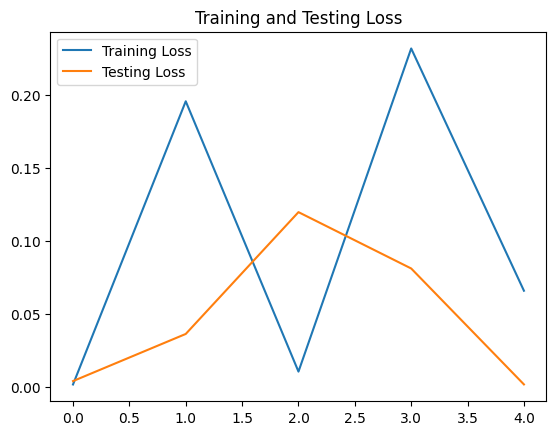

In [ ]:
# train_losses = [t1.item() for t1 in train_losses] # Removed redundant line

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()

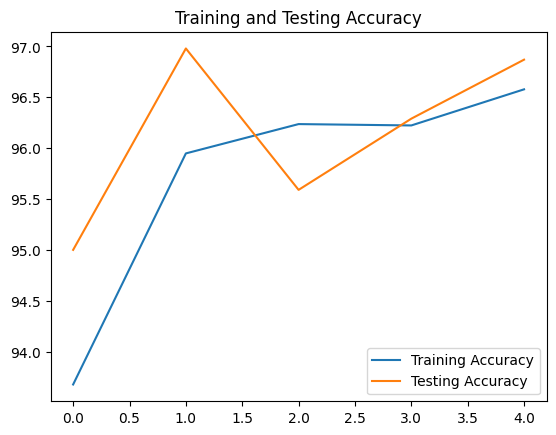

In [ ]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Testing Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle= False)

# **Test Accuracy**

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

print(f'Test Accuracy: {correct/10000}')


Test Accuracy: 0.9686999917030334


Enter the index of the test data to display: 2001


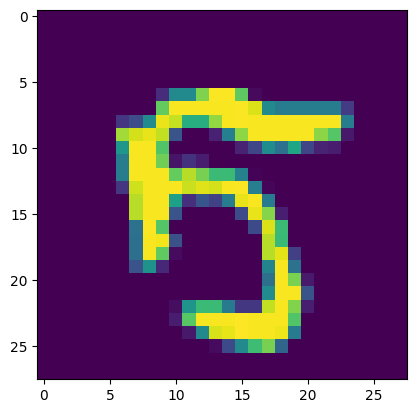

In [ ]:
# Show the image
index = int(input("Enter the index of the test data to display: "))
plt.imshow(test_data[index][0].reshape(28,28))

In [ ]:
# Grab an image
test_data[index] #Tensor with an image in it...at the end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# Grab just the data
test_data[index][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
# Reshape it
test_data[index][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
# Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[index][0].view(1,1,28,28))
  # batch size of 1, 1 color channel, 28x28 image

In [ ]:
# Check the new prediction..get probabilites
new_prediction

tensor([[ -61.5876,  -94.7186,  -80.4243,  -42.0447, -120.3582,    0.0000,
          -45.6651, -150.5507,  -50.5353,  -50.9043]])

In [ ]:
new_prediction.argmax()

tensor(5)

In [ ]:
print(f'The model predicts: {new_prediction.argmax().item()}')

The model predicts: 5


In [ ]:
print(f'The actual label is: {test_data[index][1]}')

The actual label is: 5


**Reasoning**:
Set the model to evaluation mode and initialize a list to store predictions. Then, iterate through the test loader to get predictions for the entire test dataset.



In [ ]:
model.eval()
test_predictions = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        test_predictions.extend(predicted.tolist())

## Get all true labels

### Subtask:
Get the true labels for the entire test dataset.


**Reasoning**:
Initialize an empty list to store the true labels and iterate through the test loader to collect the true labels from each batch.



In [ ]:
test_true_labels = []
for b, (X_test, y_test) in enumerate(test_loader):
    test_true_labels.extend(y_test.tolist())

## Calculate confusion matrix

### Subtask:
Use the predictions and true labels to calculate the confusion matrix.


**Reasoning**:
Import the confusion_matrix function and calculate the confusion matrix using the true labels and predictions.



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_true_labels, test_predictions)

## Visualize confusion matrix

### Subtask:
Display the confusion matrix as a heatmap for better visualization.


**Reasoning**:
Create a heatmap of the confusion matrix using seaborn.



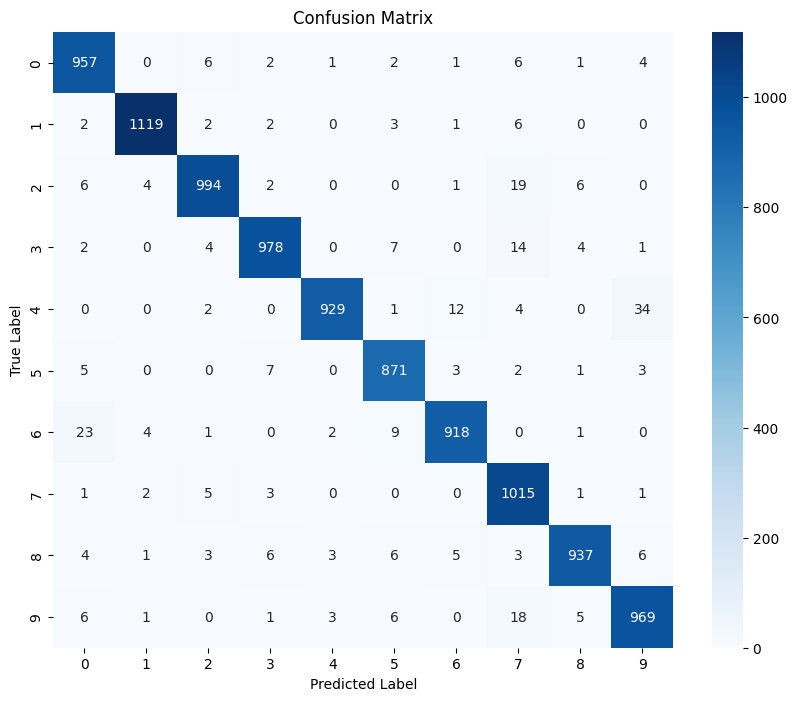

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()